# Descomposición del DOM

In [68]:
from bs4 import BeautifulSoup
from collections import Counter
from pathlib import Path

## Definiciones y utilidades estructurales

In [69]:
MAX_DEPTH = 12

IGNORED_TAGS = {
    "script", "style", "link", "meta", "svg", "noscript"
}

def normalize_classes(tag):
    return tuple(sorted(tag.get("class", [])))


def structural_fingerprint(tag, depth):
    if depth > MAX_DEPTH:
        return None
    if not tag.name or tag.name in IGNORED_TAGS:
        return None

    return (
        tag.name,
        normalize_classes(tag),
        depth
    )

def children_fingerprints(tag, depth):
    fps = []
    for child in tag.children:
        if getattr(child, "name", None):
            fp = structural_fingerprint(child, depth + 1)
            if fp:
                fps.append(fp)
    return Counter(fps)


In [70]:
def extract_structure(soup):
    structure = {}

    def walk(tag, depth=0):
        fp = structural_fingerprint(tag, depth)
        if not fp:
            return

        structure.setdefault(fp, []).append(
            children_fingerprints(tag, depth)
        )

        for child in tag.children:
            if getattr(child, "name", None):
                walk(child, depth + 1)

    walk(soup.body)
    return structure

In [71]:
def compare_structures(struct_a, struct_b):
    dynamic_candidates = []

    for key in set(struct_a) & set(struct_b):
        if struct_a[key] != struct_b[key]:
            dynamic_candidates.append(key)

    return dynamic_candidates

In [72]:
def load_html(path):
    return BeautifulSoup(
        Path(path).read_text(encoding="utf-8"),
        "html.parser"
    )

## extracción estructural

In [73]:
soup1 = load_html("data/raw/chrome.html")
soup2 = load_html("data/raw/firefox.html")

struct1 = extract_structure(soup1)
struct2 = extract_structure(soup2)

## Detección de zonas dinámicas (general)

In [74]:
dynamic_nodes = compare_structures(struct1, struct2)

for tag, classes, depth in dynamic_nodes:
    print(f"Tag: {tag}, Classes: {classes}, Depth: {depth}")

Tag: span, Classes: ('oUAcPd',), Depth: 10
Tag: div, Classes: (), Depth: 9
Tag: span, Classes: (), Depth: 6
Tag: div, Classes: ('Fgyi2e', 'caNvfd', 'rZj61'), Depth: 3
Tag: div, Classes: ('Tg0csd',), Depth: 3
Tag: div, Classes: (), Depth: 11
Tag: div, Classes: (), Depth: 4
Tag: div, Classes: ('A6K0A',), Depth: 10
Tag: div, Classes: (), Depth: 6
Tag: div, Classes: ('e9EfHf',), Depth: 2
Tag: div, Classes: (), Depth: 8
Tag: div, Classes: (), Depth: 10
Tag: div, Classes: (), Depth: 3
Tag: div, Classes: (), Depth: 12
Tag: div, Classes: ('MjjYud',), Depth: 9
Tag: div, Classes: ('dURPMd',), Depth: 8


## Filtrado semántico de candidatos dinámicos

In [75]:
def is_relevant_candidate(tag, classes, depth):
    if not classes:
        return False
    if tag not in {"div", "section", "article"}:
        return False
    if depth < 2 or depth > 9:
        return False
    return True

In [76]:
print("Zonas dinámicas candidatas:\n")

for tag, classes, depth in dynamic_nodes:
    if is_relevant_candidate(tag, classes, depth):
        print(f"Tag: {tag}, Classes: {classes}, Depth: {depth}")

Zonas dinámicas candidatas:

Tag: div, Classes: ('Fgyi2e', 'caNvfd', 'rZj61'), Depth: 3
Tag: div, Classes: ('Tg0csd',), Depth: 3
Tag: div, Classes: ('e9EfHf',), Depth: 2
Tag: div, Classes: ('MjjYud',), Depth: 9
Tag: div, Classes: ('dURPMd',), Depth: 8


## Clasificación: contenedores dinámicos repetitivos dominantes

    un solo patrón que cubre ≥ 60%

In [77]:
SEMANTIC_TAGS = {
    "article", "section", "li", "p", "a",
    "img", "h1", "h2", "h3", "h4",
    "ul", "ol", "figure"
}

def semantic_signature(tag, max_depth=3, depth=0):
    """
    Devuelve una huella semántica normalizada del subárbol.
    """
    if depth > max_depth:
        return None

    if not tag.name or tag.name in IGNORED_TAGS:
        return None

    # decidir si el nodo es semánticamente relevante
    is_semantic = (
        tag.name in SEMANTIC_TAGS or
        bool(tag.get("class"))
    )

    children_signatures = []

    for child in tag.children:
        if getattr(child, "name", None):
            sig = semantic_signature(child, max_depth, depth + 1)
            if sig:
                children_signatures.append(sig)

    # colapsar wrappers no semánticos
    if not is_semantic and len(children_signatures) == 1:
        return children_signatures[0]

    # firma final
    return (
        tag.name,
        tuple(sorted(tag.get("class", [])[:2])),  # no todas
        tuple(children_signatures)
    )

#def item_fingerprint(tag):
#    """
#    Huella ligera para detectar items repetidos dentro de un contenedor
#    """
#    return (
#        tag.name,
#        tuple(sorted(tag.get("class", [])))
#    )

def item_fingerprint(tag):
    return semantic_signature(tag)

In [78]:
def find_matching_children(container, target_signature):
    matches = []

    for child in container.children:
        if getattr(child, "name", None):
            if semantic_signature(child) == target_signature:
                matches.append(child)

    return matches

In [79]:
def extract_child_patterns(tag):
    patterns = []

    for child in tag.children:
        if getattr(child, "name", None):
            if child.name in IGNORED_TAGS:
                continue
            patterns.append(item_fingerprint(child))

    return Counter(patterns)

In [80]:
def extract_repeated_patterns(
    child_counter,
    min_repetitions=2,
    coverage_threshold=0.6
):
    """
    Devuelve todos los patrones repetidos que,
    en conjunto, cubren la mayor parte del contenedor.
    """
    total = sum(child_counter.values())
    if total == 0:
        return {}

    repeated = {
        pattern: count
        for pattern, count in child_counter.items()
        if count >= min_repetitions
    }

    if not repeated:
        return {}

    coverage = sum(repeated.values()) / total

    if coverage >= coverage_threshold:
        return repeated

    return {}

In [81]:
def find_real_nodes(soup, target_fp):
    tag_name, classes, depth = target_fp
    results = []

    def walk(tag, current_depth=0):
        if current_depth > MAX_DEPTH:
            return

        if (
            tag.name == tag_name and
            tuple(sorted(tag.get("class", []))) == classes and
            current_depth == depth
        ):
            results.append(tag)

        for child in tag.children:
            if getattr(child, "name", None):
                walk(child, current_depth + 1)

    walk(soup.body)
    return results

### emisión de selectores CSS estructurales

In [82]:
def build_css_selector(tag, classes):
    if classes:
        return tag + "." + ".".join(classes)
    return tag


In [83]:
import hashlib

def signature_id(signature):
    return hashlib.sha1(str(signature).encode()).hexdigest()[:8]

In [84]:
## Emisión de contenedores dinámicos repetitivos DOMINANTES

DOMINANCE_THRESHOLD = 0.6  # 60%

dynamic_containers = []

for fp in dynamic_nodes:
    tag, classes, depth = fp

    if not is_relevant_candidate(tag, classes, depth):
        continue

    nodes = find_real_nodes(soup1, fp)
    if not nodes:
        continue

    node = nodes[0]

    child_patterns = extract_child_patterns(node)
    repeated_patterns = extract_repeated_patterns(child_patterns)

    if not repeated_patterns:
        continue

    total_children = sum(child_patterns.values())

    # ordenar grupos repetidos por cantidad
    sorted_groups = sorted(
        repeated_patterns.items(),
        key=lambda x: x[1],
        reverse=True
    )

    dominant_signature, dominant_count = sorted_groups[0]
    dominance_ratio = dominant_count / total_children

    # condición CLAVE: solo dominantes
    if dominance_ratio < DOMINANCE_THRESHOLD:
        continue

    # si hay más de un grupo con peso significativo, no es dominante
    if len(sorted_groups) > 1:
        second_ratio = sorted_groups[1][1] / total_children
        if second_ratio >= (1 - DOMINANCE_THRESHOLD):
            continue

    matched_nodes = find_matching_children(node, dominant_signature)
    if not matched_nodes:
        continue

    representative = matched_nodes[0]

    feed = {
        "container": build_css_selector(tag, classes),
        "items": [{
            "selector": "> " + build_css_selector(
                representative.name,
                tuple(sorted(representative.get("class", [])))
            ),
            "signature": signature_id(dominant_signature),
            "count": dominant_count,
            "coverage": round(dominance_ratio, 2)
        }],
        "type": "dominant"
    }

    dynamic_containers.append(feed)

dynamic_containers

[]

## Clasificación: contenedores dinámicos repetitivos compuesto

    No tiene un único patrón dominante, sino dos o más patrones de hijos repetidos.

    La suma de esos patrones repetidos cubre la mayor parte del contenedor.

In [85]:
def extract_repeated_patterns(
    child_counter,
    min_repetitions=2,
    coverage_threshold=0.6
):
    """
    Devuelve todos los patrones repetidos que, en conjunto,
    cubren una parte significativa del contenedor.
    """
    total = sum(child_counter.values())
    if total == 0:
        return {}

    repeated = {
        pattern: count
        for pattern, count in child_counter.items()
        if count >= min_repetitions
    }

    if not repeated:
        return {}

    coverage = sum(repeated.values()) / total

    if coverage >= coverage_threshold:
        return repeated

    return {}


In [86]:
print("Contenedores dinámicos repetitivos compuestos:\n")

COMPOSED_DOMINANCE_THRESHOLD = 0.6

containers = []

for fp in dynamic_nodes:
    tag, classes, depth = fp

    if not is_relevant_candidate(tag, classes, depth):
        continue

    nodes = find_real_nodes(soup1, fp)
    if not nodes:
        continue

    node = nodes[0]

    child_patterns = extract_child_patterns(node)
    repeated = extract_repeated_patterns(child_patterns)

    if len(repeated) < 2:
        continue  # un solo grupo no es compuesto

    total_children = sum(child_patterns.values())

    # calcular coberturas
    coverages = {
        signature: count / total_children
        for signature, count in repeated.items()
    }

    # si alguno es dominante → no es compuesto
    if any(cov >= COMPOSED_DOMINANCE_THRESHOLD for cov in coverages.values()):
        continue

    items = []

    for signature, count in repeated.items():
        matched_nodes = find_matching_children(node, signature)
        if not matched_nodes:
            continue

        representative = matched_nodes[0]

        selector = "> " + build_css_selector(
            representative.name,
            tuple(sorted(representative.get("class", [])))
        )

        items.append({
            "selector": selector,
            "signature": signature_id(signature),
            "count": count,
            "coverage": round(count / total_children, 2)
        })

    if len(items) < 2:
        continue

    container = {
        "container": build_css_selector(tag, classes),
        "items": items,
        "type": "composed"
    }

    containers.append(container)

containers


Contenedores dinámicos repetitivos compuestos:



[{'container': 'div.dURPMd',
  'items': [{'selector': '> div.MjjYud',
    'signature': 'bc7b5d12',
    'count': 8,
    'coverage': 0.4},
   {'selector': '> div.MjjYud',
    'signature': '3b7d1a71',
    'count': 7,
    'coverage': 0.35}],
  'type': 'composed'}]

## Clasificación: contenedores dinámicos repetitivos Mixtos

    La repetición NO cubre la mayor parte del contenedor.

Coexisten:
*   hijos repetidos
*   hijos únicos / heterogéneos

In [87]:
def extract_mixed_repetition(
    child_counter,
    min_repetitions=2,
    coverage_threshold=0.6
):
    """
    Devuelve patrones repetidos cuya cobertura es parcial
    (no dominante ni compuesta).
    """
    total = sum(child_counter.values())
    if total == 0:
        return {}

    repeated = {
        pattern: count
        for pattern, count in child_counter.items()
        if count >= min_repetitions
    }

    if not repeated:
        return {}

    coverage = sum(repeated.values()) / total

    if 0 < coverage < coverage_threshold:
        return repeated

    return {}

In [88]:
print("Contenedores dinámicos repetitivos mixtos:\n")

mixed_containers = []

for fp in dynamic_nodes:
    tag, classes, depth = fp

    if not is_relevant_candidate(tag, classes, depth):
        continue

    nodes = find_real_nodes(soup1, fp)
    if not nodes:
        continue

    node = nodes[0]

    child_patterns = extract_child_patterns(node)

    mixed_patterns = extract_mixed_repetition(child_patterns)
    if not mixed_patterns:
        continue

    items = []

    total_children = sum(child_patterns.values())

    for signature, count in mixed_patterns.items():
        matched_nodes = find_matching_children(node, signature)
        if not matched_nodes:
            continue

        representative = matched_nodes[0]

        selector = "> " + build_css_selector(
            representative.name,
            tuple(sorted(representative.get("class", [])))
        )

        items.append({
            "selector": selector,
            "signature": signature_id(signature),
            "count": count,
            "coverage": round(count / total_children, 2)
        })

    if not items:
        continue

    mixed_containers.append({
        "container": build_css_selector(tag, classes),
        "items": items,
        "type": "mixed"
    })

mixed_containers

Contenedores dinámicos repetitivos mixtos:



[{'container': 'div.e9EfHf',
  'items': [{'selector': '> div',
    'signature': 'cae9c489',
    'count': 6,
    'coverage': 0.27}],
  'type': 'mixed'}]

<hr>

## Clasificación: contenedores dinámicos no repetitivos

*   No contiene repetición estructural suficiente en sus hijos

Pero sigue siendo relevante porque:

*   Contiene información variable

*   Puede cambiar por estado, contexto o usuario

*   No es ruido (scripts, estilos, wrappers técnicos)

    Un bloque estructuralmente inestable que concentra información relevante y que no puede tratarse como lista ni como ítems homogéneos.

In [89]:
def container_complexity(child_counter):
    total = sum(child_counter.values())
    unique = len(child_counter)
    return {
        "total_children": total,
        "unique_children": unique
    }

In [90]:
print("Contenedores dinámicos no repetitivos:\n")

non_repetitive_containers = []

for fp in dynamic_nodes:
    tag, classes, depth = fp

    if not is_relevant_candidate(tag, classes, depth):
        continue

    nodes = find_real_nodes(soup1, fp)
    if not nodes:
        continue

    node = nodes[0]

    child_patterns = extract_child_patterns(node)

    # Si tiene repetición, no es no-repetitivo
    if extract_repeated_patterns(child_patterns):
        continue

    if extract_mixed_repetition(child_patterns):
        continue

    # Métricas básicas
    metrics = container_complexity(child_patterns)

    # Filtro de ruido
    if metrics["total_children"] < 3:
        continue

    non_repetitive_containers.append({
        "container": build_css_selector(tag, classes),
        "type": "non_repetitive",
        "metrics": metrics
    })

non_repetitive_containers


Contenedores dinámicos no repetitivos:



[]

## Detección de zonas estables

No cambian entre sesiones.

Su huella estructural coincide entre HTMLs.

No repetitivos

No son listas ni feeds.

No contienen patrones de hijos repetidos significativos.

Relevantes

No son layout puro.

No son navegación, footer, header genérico.

Contienen información o interacción útil.

In [91]:
import hashlib
from bs4 import Tag

In [92]:
#Huella estructural estable (subárbol limitado)
def structural_signature(node, max_depth=3):
    def walk(n, depth):
        if depth > max_depth or not isinstance(n, Tag):
            return None

        sig = {
            "tag": n.name,
            "children": []
        }

        for child in n.children:
            if isinstance(child, Tag):
                child_sig = walk(child, depth + 1)
                if child_sig:
                    sig["children"].append(child_sig)

        return sig

    raw = walk(node, 0)
    serialized = str(raw).encode("utf-8")
    return hashlib.md5(serialized).hexdigest()


In [93]:
#Indexar nodos estables por huella
def index_structural_nodes(soup, min_children=2):
    index = {}

    for node in soup.find_all(True):
        if not isinstance(node, Tag):
            continue

        # Filtro de ruido
        children = [c for c in node.children if isinstance(c, Tag)]
        if len(children) < min_children:
            continue

        sig = structural_signature(node)

        index.setdefault(sig, []).append(node)

    return index

In [94]:
#construir indices de ambas sesiones
index1 = index_structural_nodes(soup1)
index2 = index_structural_nodes(soup2)

In [95]:
#Eliminar dinámicos conocidos
def dynamic_fingerprint_set(dynamic_nodes):
    return {
        (tag, tuple(classes), depth)
        for tag, classes, depth in dynamic_nodes
    }

dynamic_fp = dynamic_fingerprint_set(dynamic_nodes)


In [96]:
stable_zones = []

for sig in index1:
    if sig not in index2:
        continue  # no persiste entre sesiones

    nodes1 = index1[sig]
    nodes2 = index2[sig]

    # Debe ser único (no repetitivo)
    if len(nodes1) != 1 or len(nodes2) != 1:
        continue

    node = nodes1[0]

    tag = node.name
    classes = tuple(sorted(node.get("class", [])))
    depth = len(list(node.parents))

    fp = (tag, classes, depth)

    # Excluir zonas dinámicas
    if fp in dynamic_fp:
        continue

    # Filtro estructural básico
    if depth < 2 or depth > 8:
        continue

    stable_zones.append(fp)

stable_zones


[('noscript', (), 3),
 ('div', ('S6VXfe',), 4),
 ('div', (), 5),
 ('div', ('NDnoQ', 'P3mIxe'), 6),
 ('form', ('tsf',), 7),
 ('div', ('Efnghe', 'Q3DXx'), 7),
 ('div', ('uZkjhb',), 8),
 ('div', ('YNk70c', 'iFBYke'), 7),
 ('div', ('eqAnXb',), 7),
 ('div', (), 7),
 ('div', (), 7),
 ('div', ('spch',), 5),
 ('div', ('spchc',), 6),
 ('div', ('inner-container',), 7),
 ('div', ('button-container',), 8),
 ('div', ('puIGge',), 5)]

#

## Clasificación: contenedores estables relevantes

In [101]:
import re

GENERIC_CLASS_PATTERNS = re.compile(
    r"(container|wrapper|inner|layout|content)",
    re.IGNORECASE
)

INTERACTIVE_TAGS = {"a", "button", "input", "select", "textarea"}
SEMANTIC_TAGS = {"nav", "main", "article", "section", "form", "header", "footer"}

In [103]:
def resolve_node_from_selector(soup, selector):
    try:
        return soup.select_one(selector)
    except Exception:
        return None

In [100]:
def has_meaningful_text(tag, min_chars=40):
    text = tag.get_text(strip=True)
    return len(text) >= min_chars


def has_interactive_elements(tag):
    return bool(tag.find(INTERACTIVE_TAGS))


def has_semantic_structure(tag):
    return bool(tag.find(SEMANTIC_TAGS))


def is_generic_selector(selector):
    if "." not in selector:
        return True
    return bool(GENERIC_CLASS_PATTERNS.search(selector))

In [ ]:
def emit_stable_containers(stable_zones, soup):
    containers = []

    for tag, classes, depth in stable_zones:
        selector = build_css_selector(tag, classes)

        node = resolve_node_from_selector(soup, selector)
        if not node:
            continue

        containers.append({
            "tag": tag,
            "classes": classes,
            "depth": depth,
            "selector": selector,
            "node": node
        })

    return containers

In [104]:
stable_containers = emit_stable_containers(stable_zones, soup1)

In [105]:
def filter_relevant_stable_containers(stable_containers):
    relevant = []

    for c in stable_containers:
        selector = c["selector"]
        node = c["node"]

        # Exclusiones duras
        if selector.split(".")[0] in IGNORED_TAGS:
            continue

        if is_generic_selector(selector):
            continue

        # Criterios positivos
        if (
            has_meaningful_text(node)
            or has_interactive_elements(node)
            or has_semantic_structure(node)
        ):
            relevant.append(c)

    return relevant


In [106]:
relevant_stable_containers = filter_relevant_stable_containers(
    stable_containers
)

[{'tag': 'div',
  'classes': ('S6VXfe',),
  'depth': 4,
  'selector': 'div.S6VXfe',
  'node': <div class="S6VXfe"><a class="gyPpGe" data-ved="0ahUKEwiJh4vzxPCRAxVZr5UCHWNaDk4Q67oDCAU" jsaction="i3viod" jsname="BKxS1e" role="link" tabindex="0">Ir al contenido principal</a><a class="gyPpGe" href="https://support.google.com/websearch/answer/181196?hl=es-419" jsname="KI37ad" ping="/url?sa=t&amp;source=web&amp;rct=j&amp;url=https://support.google.com/websearch/answer/181196%3Fhl%3Des-419&amp;ved=0ahUKEwiJh4vzxPCRAxVZr5UCHWNaDk4QwcMDCAY&amp;opi=89978449">Ayuda sobre la accesibilidad</a><div data-async-context="async_id:duf3-78;authority:0;card_id:;entry_point:0;feature_id:;ftoe:0;header:0;is_jobs_spam_form:0;open:0;preselect_answer_index:-1;suggestions:;suggestions_subtypes:;suggestions_types:;surface:0;title:;type:78"><div jsaction="rcuQ6b:npT2md" jscontroller="EkevXb" style="display:none"></div><div class="yp" data-async-context-required="type,open,feature_id,async_id,entry_point,authority
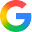
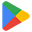
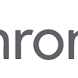
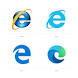
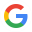

In [107]:
relevant_stable_containers

<hr>

# Motor de Inferencia

In [ ]:
from dotenv import load_dotenv
import google.generativeai as genai
import zipfile
import os
import re

In [ ]:
load_dotenv()

api_key = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=api_key)
model = genai.GenerativeModel("gemini-2.5-flash")

In [ ]:
def generar_extension(prompt_principal, identificadores=None, codigo_referencia=None):
    """
    Genera el código de una extensión de Google Chrome en base a un prompt e información adicional.
    """
    
    mensaje = f""" Eres un **Generador Experto de Extensiones de Google Chrome (Manifest V3)**.

Tu objetivo es crear una extensión de Chrome **completamente funcional, segura y lista para cargar**, basándote rigurosamente en las instrucciones proporcionadas.

### Directrices Clave de Generación

1.  **Seguridad y Manifest V3 (CRUCIAL):**
    * **NO** se debe utilizar código JavaScript *inline* (ej. `<script>...</script>`) en archivos HTML (como `popup.html`). Todo JavaScript debe estar en archivos `.js` externos.
    * El archivo `manifest.json` debe estar configurado para **Manifest V3** y cumplir con las políticas de seguridad (CSP).
    * **NO** se debe hacer referencia a iconos, imágenes, fuentes o cualquier archivo externo que no esté estrictamente incluido en el código fuente de la respuesta.
2.  **Archivos:** Los archivos generados deben ser **autocontenidos** y **funcionales**.
3.  **Salida Estricta:** La respuesta debe contener **solamente** el código fuente de la extensión, **sin preámbulos, explicaciones, comentarios o texto adicional**.

---

### Parámetros de Extensión

**--- Instrucciones Principales (Función de la Extensión) ---**
{prompt_principal.strip()}

---

### Formato de Salida

Devuelve **únicamente** el código fuente, respetando **exactamente** el siguiente formato de bloques:

--- archivo: manifest.json ---
(contenido completo del archivo)
--- fin archivo ---

--- archivo: background.js ---
(contenido completo del archivo)
--- fin archivo ---

--- archivo: popup.html ---
(contenido completo del archivo, con el script JS enlazado externamente)
--- fin archivo ---

*(Incluye otros archivos, como `.js` o `.css`, solo si son necesarios para la funcionalidad, siguiendo el mismo formato de bloque.)*

--- archivo: popup.js ---
(contenido completo del archivo JS externo para popup.html)
--- fin archivo ---
. """

    respuesta = model.generate_content(mensaje)
    #generar_archivos_extension(respuesta.text)
    return respuesta.text

In [ ]:
prompt = """Crea una extensión de Chrome que, al hacer clic en su icono, abra un popup que muestre una lista de las últimas 5 noticias tecnológicas de un sitio web popular. La extensión debe permitir al usuario actualizar la lista manualmente mediante un botón "Actualizar". Utiliza HTML, CSS y JavaScript para el diseño y la funcionalidad del popup. Asegúrate de que la extensión cumpla con las políticas de seguridad de Chrome y utilice Manifest V3."""

In [ ]:
#generar_extension(prompt)